# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import os
import numpy as np
from fduml.utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
# dir = os.path.dirname(os.path.realpath(__file__))
# cifar10_dir = os.path.join(dir, 'datasets/cifar')

cifar10_dir = 'datasets/cifar'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


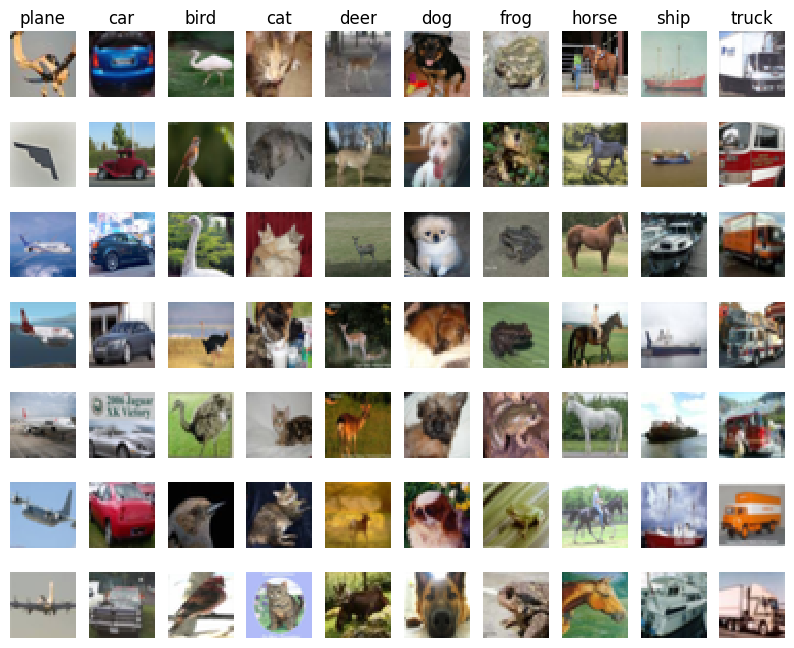

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


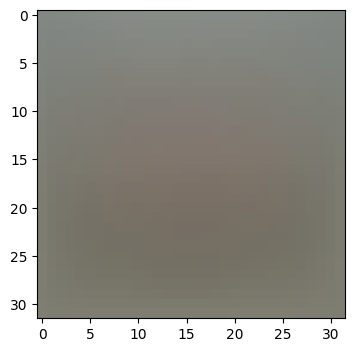

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `Exercise3/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from fduml.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.189062


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from fduml.utils import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 8.602026 analytic: 8.602026, relative error: 3.080242e-11
numerical: -11.440312 analytic: -11.440312, relative error: 3.903818e-11
numerical: 4.775605 analytic: 4.775605, relative error: 4.543829e-11
numerical: 26.389013 analytic: 26.389013, relative error: 1.295126e-12
numerical: 12.764227 analytic: 12.764227, relative error: 1.250588e-11
numerical: -2.986766 analytic: -2.986766, relative error: 1.360154e-10
numerical: -0.794244 analytic: -0.794244, relative error: 3.103043e-10
numerical: -41.469214 analytic: -41.469214, relative error: 1.203765e-11
numerical: 16.529768 analytic: 16.529768, relative error: 4.836745e-12
numerical: 16.398310 analytic: 16.398310, relative error: 1.522332e-11
numerical: 17.762266 analytic: 17.762266, relative error: 1.995916e-11
numerical: -23.091806 analytic: -23.091806, relative error: 1.683492e-11
numerical: 3.432291 analytic: 3.432291, relative error: 1.188472e-12
numerical: 15.479857 analytic: 15.412921, relative error: 2.166717e-03
numeri

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from fduml.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.189062e+00 computed in 0.066337s
Vectorized loss: 9.189062e+00 computed in 0.005132s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.070103s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from fduml.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 794.282765
iteration 100 / 1500: loss 288.893503
iteration 200 / 1500: loss 108.338048
iteration 300 / 1500: loss 42.409032
iteration 400 / 1500: loss 19.049029
iteration 500 / 1500: loss 10.766387
iteration 600 / 1500: loss 7.075305
iteration 700 / 1500: loss 6.662971
iteration 800 / 1500: loss 5.818548
iteration 900 / 1500: loss 5.303493
iteration 1000 / 1500: loss 5.254897
iteration 1100 / 1500: loss 5.487400
iteration 1200 / 1500: loss 5.645397
iteration 1300 / 1500: loss 5.234050
iteration 1400 / 1500: loss 5.513944
That took 4.328969s


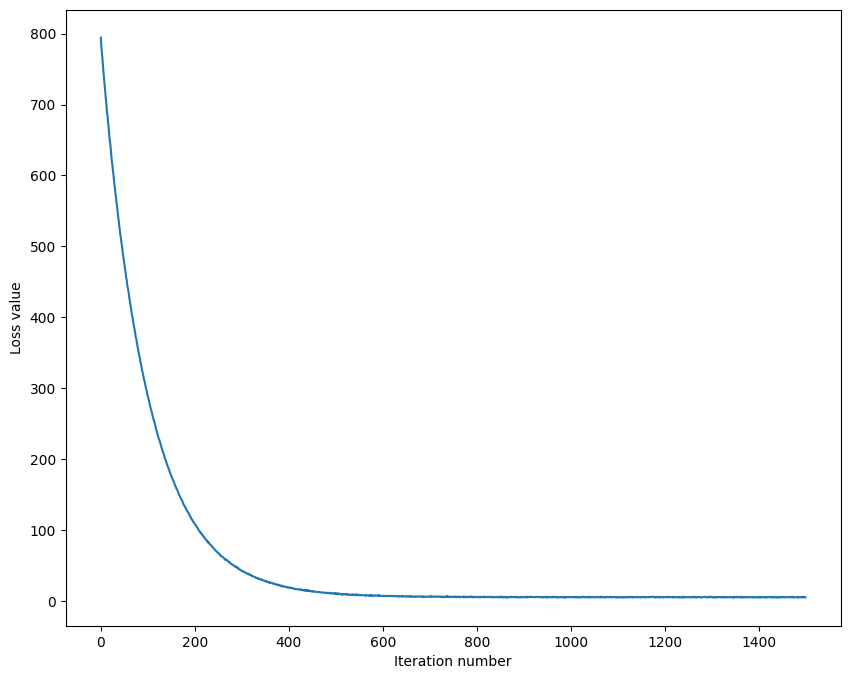

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369653
validation accuracy: 0.390000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 扩展搜索范围以获得更好的结果
learning_rates = [1e-8, 1e-7, 1e-6, 5e-5]
regularization_strengths = [1e4, 2.5e4, 5e4, 7.5e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        # 训练模型
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        # 计算训练和验证准确率
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        # 存储结果
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        # 更新最佳模型
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

c:\Users\13004\Desktop\LAB\ML - Lab\1\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:95: RuntimeWarning: overflow encountered in scalar multiply
  loss = np.sum(margins) / num_train + reg * np.sum(W * W)
c:\Users\13004\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\13004\Desktop\LAB\ML - Lab\1\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:95: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margins) / num_train + reg * np.sum(W * W)
c:\Users\13004\Desktop\LAB\ML - Lab\1\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:93: RuntimeWarning: overflow encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores + 1)
c:\Users\13004\Desktop\LAB\ML - Lab\1\FDU-PRML-2024Fall\Exercise\Exercise3\fduml\linear_svm.py:115: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + 2 * reg * W


lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.231776 val accuracy: 0.234000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.248224 val accuracy: 0.260000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.294633 val accuracy: 0.297000
lr 1.000000e-08 reg 7.500000e+04 train accuracy: 0.333245 val accuracy: 0.327000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.385776 val accuracy: 0.407000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.369551 val accuracy: 0.384000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.360735 val accuracy: 0.367000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.349265 val accuracy: 0.353000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.343163 val accuracy: 0.359000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.303224 val accuracy: 0.319000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.256633 val accuracy: 0.247000
lr 1.000000e-06 reg 7.500000e+04 train accuracy: 0.236286 val accuracy: 0.250000
lr 5.000000e-05 reg 1.000000

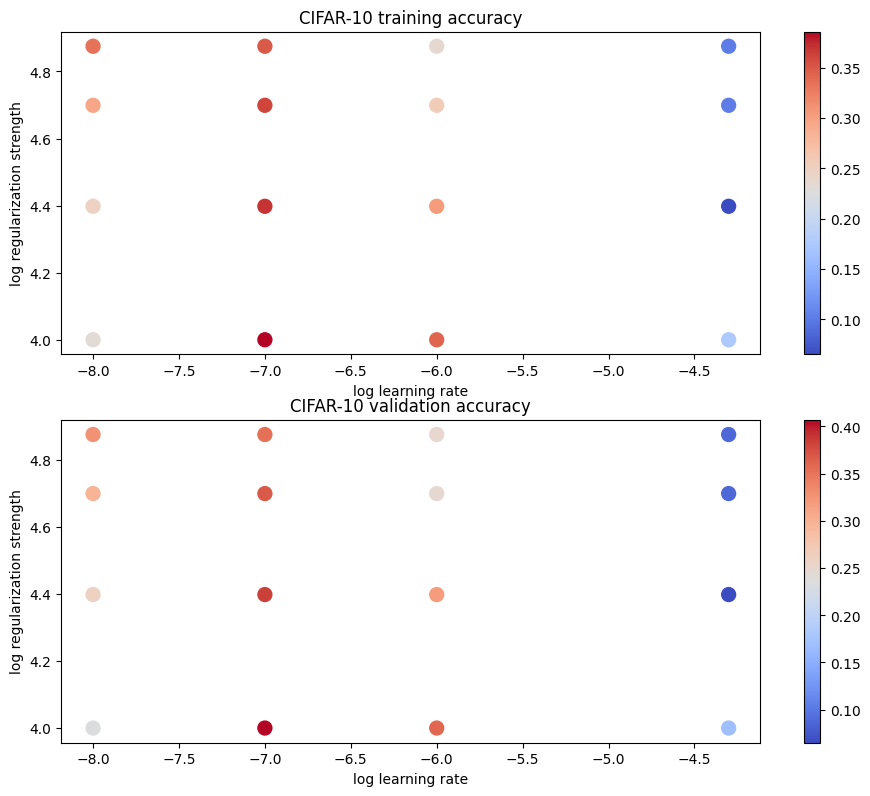

In [15]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


In [17]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 扩展搜索范围以获得更好的结果
learning_rates = [1e-8, 1e-7, 1e-6, 5e-5]
regularization_strengths = [1e4, 2.5e4, 5e4, 7.5e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        # 训练模型
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
        
        # 计算训练和验证准确率
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        # 存储结果
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        # 更新最佳模型
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.242245 val accuracy: 0.236000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.251653 val accuracy: 0.264000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.303184 val accuracy: 0.311000
lr 1.000000e-08 reg 7.500000e+04 train accuracy: 0.334061 val accuracy: 0.341000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.385510 val accuracy: 0.383000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.368469 val accuracy: 0.368000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.352469 val accuracy: 0.358000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.352694 val accuracy: 0.368000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.291857 val accuracy: 0.318000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.271551 val accuracy: 0.283000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.271551 val accuracy: 0.272000
lr 1.000000e-06 reg 7.500000e+04 train accuracy: 0.254020 val accuracy: 0.260000
lr 5.000000e-05 reg 1.000000

## Non-Linear SVM

Real life data often appears to be **not linearly separable**.  Many real-world datasets are complex, and there is no linear boundary (i.e., hyperplane) that can separate the classes. Non-linear SVMs use the **kernel trick** to project data into a higher-dimensional space, where it becomes linearly separable.

The kernel trick allows the SVM to implicitly map data into a higher-dimensional space without explicitly calculating the coordinates of the data in that space. This enables the model to capture more complex patterns in the data. Common kernels include:

- **Polynomial kernel**: $K(x, x') = (x^Tx' + 1)^d$
- **Radial basis function (RBF) kernel**: $K(x, x') = \exp(-\gamma ||x - x'||^2)$
- **Sigmoid kernel**: $K(x, x') = \tanh(\kappa x^Tx' + \theta)$

However, the use of kernels introduces a more complex optimization problem that cannot be solved by simple gradient descent. Instead, the optimization problem becomes a **quadratic programming** problem that can be solved by specialized algorithms.

In this section, we will use the `sklearn` library to train a non-linear SVM on the CIFAR-10 dataset. Your task is to:

- Train a non-linear SVM using the `sklearn` library;
- Try different kernels and kernel parameters, tuning them using the validation set;
- Report the best kernel and kernel parameters you found.
- Compare the performance of the linear SVM and non-linear SVM, including the time it takes to train the models and the accuracy on the test set.

In [19]:
from sklearn.svm import SVC

In [21]:
# 准备数据 - 使用中等大小的数据集
sample_size = 10000  # 增加到10000个训练样本
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_train_nonlinear = X_train[indices, :-1]  # 移除偏置列
y_train_small = y_train[indices]

# 验证集
val_size = 1000  # 增加到1000个验证样本
val_indices = np.random.choice(X_val.shape[0], val_size, replace=False)
X_val_nonlinear = X_val[val_indices, :-1]
y_val_small = y_val[val_indices]

# 测试集
test_size = 1000  # 增加到1000个测试样本
test_indices = np.random.choice(X_test.shape[0], test_size, replace=False)
X_test_nonlinear = X_test[test_indices, :-1]
y_test_small = y_test[test_indices]

# 扩展参数搜索空间
kernels = ['rbf', 'poly', 'sigmoid']  # 添加sigmoid核
C_values = [0.1, 1.0, 10.0]  # 增加更多C值
gamma_values = ['scale', 'auto', 0.01, 0.1]  # 增加更多gamma值
degree_values = [2, 3]  # 为多项式核添加degree参数

# 存储结果
kernel_results = {}
best_val_acc = -1
best_model = None

# 网格搜索最佳参数
for kernel in kernels:
    for C in C_values:
        for gamma in gamma_values:
            # 对于多项式核，还要尝试不同的degree
            if kernel == 'poly':
                for degree in degree_values:
                    print(f"Training SVM with kernel={kernel}, C={C}, gamma={gamma}, degree={degree}")
                    
                    # 创建和训练模型
                    start_time = time.time()
                    clf = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
                    clf.fit(X_train_nonlinear, y_train_small)
                    training_time = time.time() - start_time
                    
                    # 评估模型
                    train_accuracy = clf.score(X_train_nonlinear, y_train_small)
                    val_accuracy = clf.score(X_val_nonlinear, y_val_small)
                    
                    # 存储结果
                    kernel_results[(kernel, C, gamma, degree)] = {
                        'train_accuracy': train_accuracy,
                        'val_accuracy': val_accuracy,
                        'training_time': training_time
                    }
                    
                    # 更新最佳模型
                    if val_accuracy > best_val_acc:
                        best_val_acc = val_accuracy
                        best_model = clf
            else:
                print(f"Training SVM with kernel={kernel}, C={C}, gamma={gamma}")
                
                # 创建和训练模型
                start_time = time.time()
                clf = SVC(kernel=kernel, C=C, gamma=gamma)
                clf.fit(X_train_nonlinear, y_train_small)
                training_time = time.time() - start_time
                
                # 评估模型
                train_accuracy = clf.score(X_train_nonlinear, y_train_small)
                val_accuracy = clf.score(X_val_nonlinear, y_val_small)
                
                # 存储结果
                kernel_results[(kernel, C, gamma, None)] = {
                    'train_accuracy': train_accuracy,
                    'val_accuracy': val_accuracy,
                    'training_time': training_time
                }
                
                # 更新最佳模型
                if val_accuracy > best_val_acc:
                    best_val_acc = val_accuracy
                    best_model = clf

# 打印所有结果，按验证准确率排序
sorted_results = sorted(kernel_results.items(), 
                       key=lambda x: x[1]['val_accuracy'], 
                       reverse=True)

print("\nResults sorted by validation accuracy:")
for params, metrics in sorted_results:
    kernel, C, gamma, degree = params
    print(f"\nKernel: {kernel}")
    print(f"C: {C}")
    print(f"gamma: {gamma}")
    if degree is not None:
        print(f"degree: {degree}")
    print(f"Training accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Validation accuracy: {metrics['val_accuracy']:.4f}")
    print(f"Training time: {metrics['training_time']:.2f} seconds")

# 使用最佳模型在测试集上评估
test_accuracy = best_model.score(X_test_nonlinear, y_test_small)
print(f"\nBest model test accuracy: {test_accuracy:.4f}")

# 比较与线性SVM的性能
print("\nComparison with Linear SVM:")
print(f"Linear SVM test accuracy: {np.mean(y_test_small == best_svm.predict(X_test[test_indices])):.4f}")
print(f"Non-linear SVM test accuracy: {test_accuracy:.4f}")

# 计算并打印一些统计信息
total_time = sum(result['training_time'] for result in kernel_results.values())
avg_time = total_time / len(kernel_results)
print(f"\nTraining Statistics:")
print(f"Total training time: {total_time:.2f} seconds")
print(f"Average training time per model: {avg_time:.2f} seconds")
print(f"Number of models trained: {len(kernel_results)}")

Training SVM with kernel=rbf, C=0.1, gamma=scale
Training SVM with kernel=rbf, C=0.1, gamma=auto
Training SVM with kernel=rbf, C=0.1, gamma=0.01
Training SVM with kernel=rbf, C=0.1, gamma=0.1
Training SVM with kernel=rbf, C=1.0, gamma=scale
Training SVM with kernel=rbf, C=1.0, gamma=auto
Training SVM with kernel=rbf, C=1.0, gamma=0.01
Training SVM with kernel=rbf, C=1.0, gamma=0.1
Training SVM with kernel=rbf, C=10.0, gamma=scale
Training SVM with kernel=rbf, C=10.0, gamma=auto
Training SVM with kernel=rbf, C=10.0, gamma=0.01
Training SVM with kernel=rbf, C=10.0, gamma=0.1
Training SVM with kernel=poly, C=0.1, gamma=scale, degree=2
Training SVM with kernel=poly, C=0.1, gamma=scale, degree=3
Training SVM with kernel=poly, C=0.1, gamma=auto, degree=2
Training SVM with kernel=poly, C=0.1, gamma=auto, degree=3
Training SVM with kernel=poly, C=0.1, gamma=0.01, degree=2
Training SVM with kernel=poly, C=0.1, gamma=0.01, degree=3
Training SVM with kernel=poly, C=0.1, gamma=0.1, degree=2
Traini

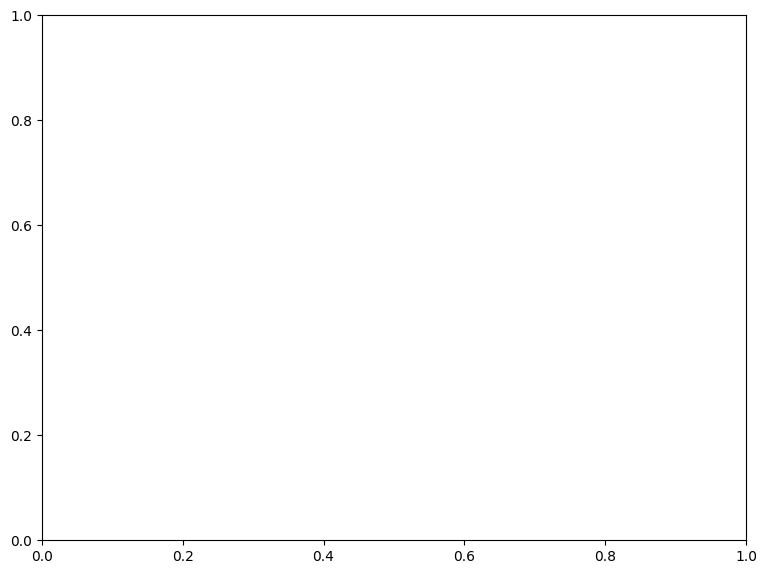

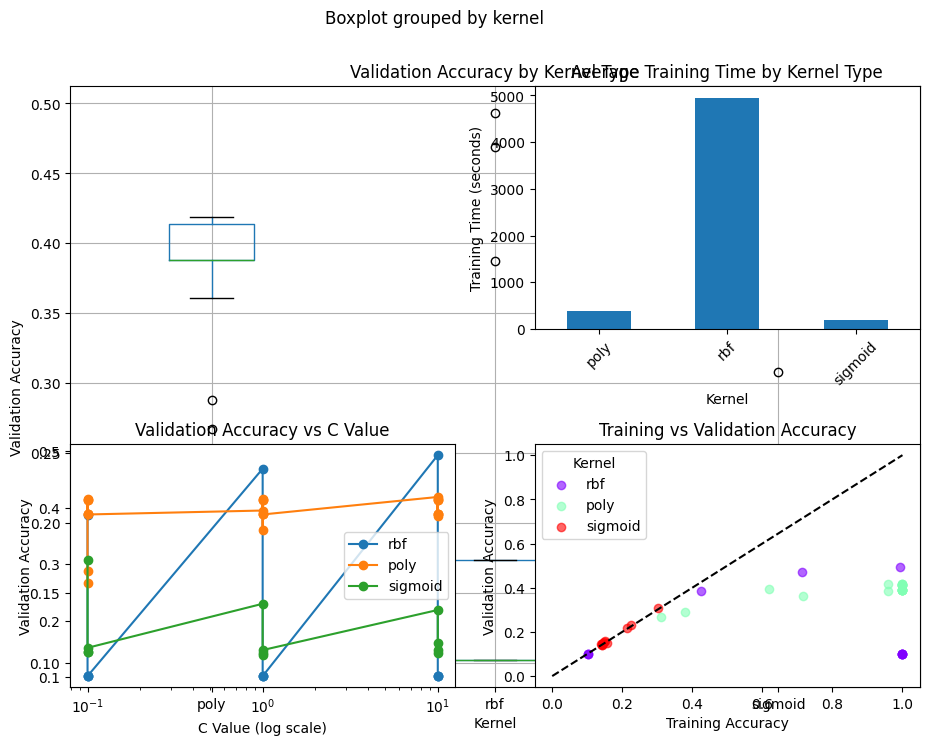

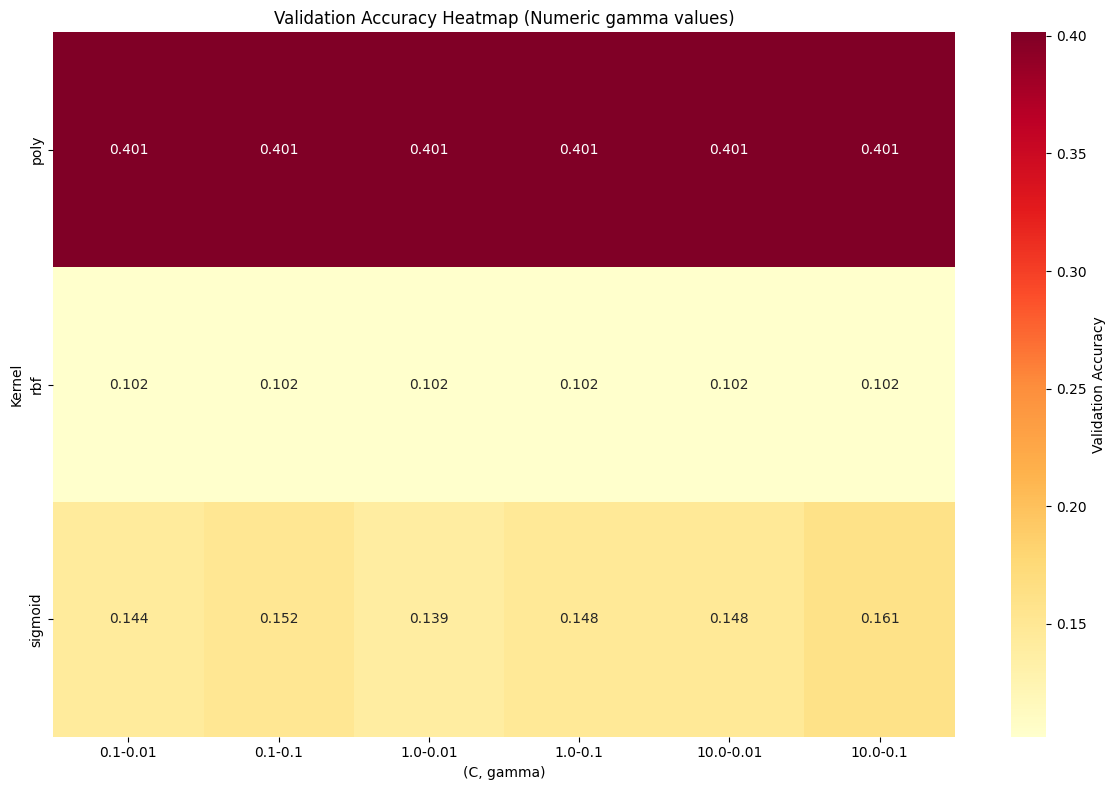

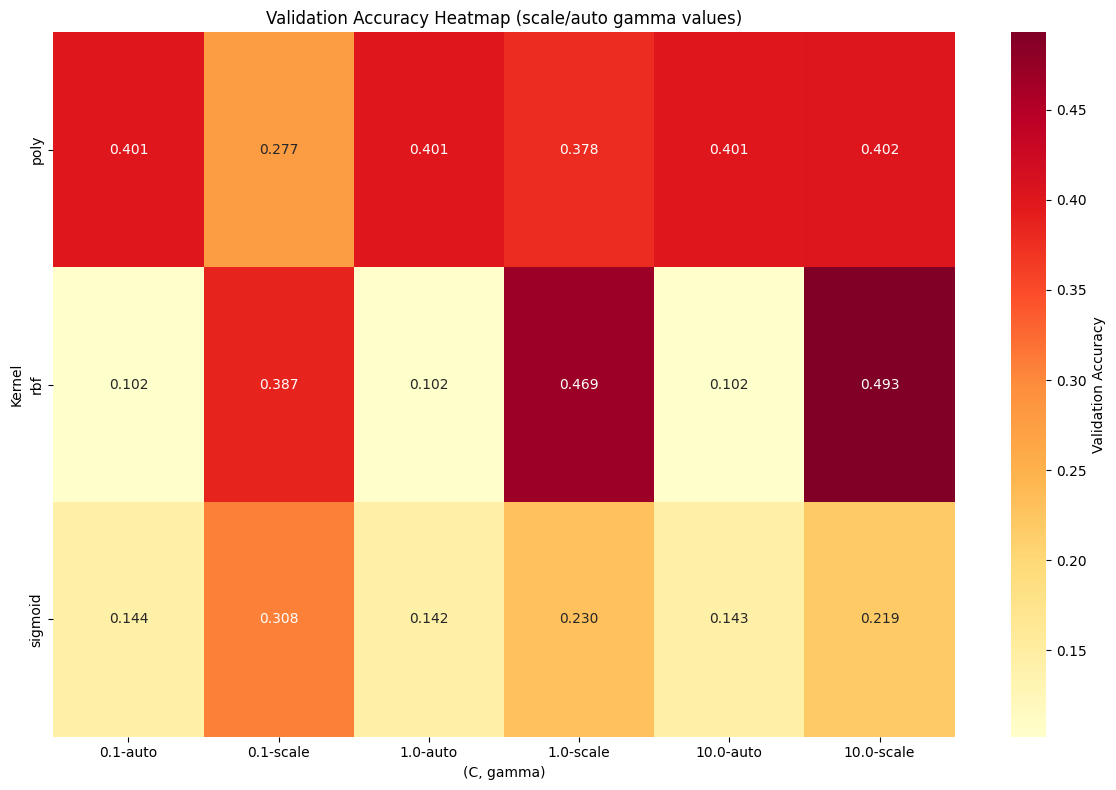

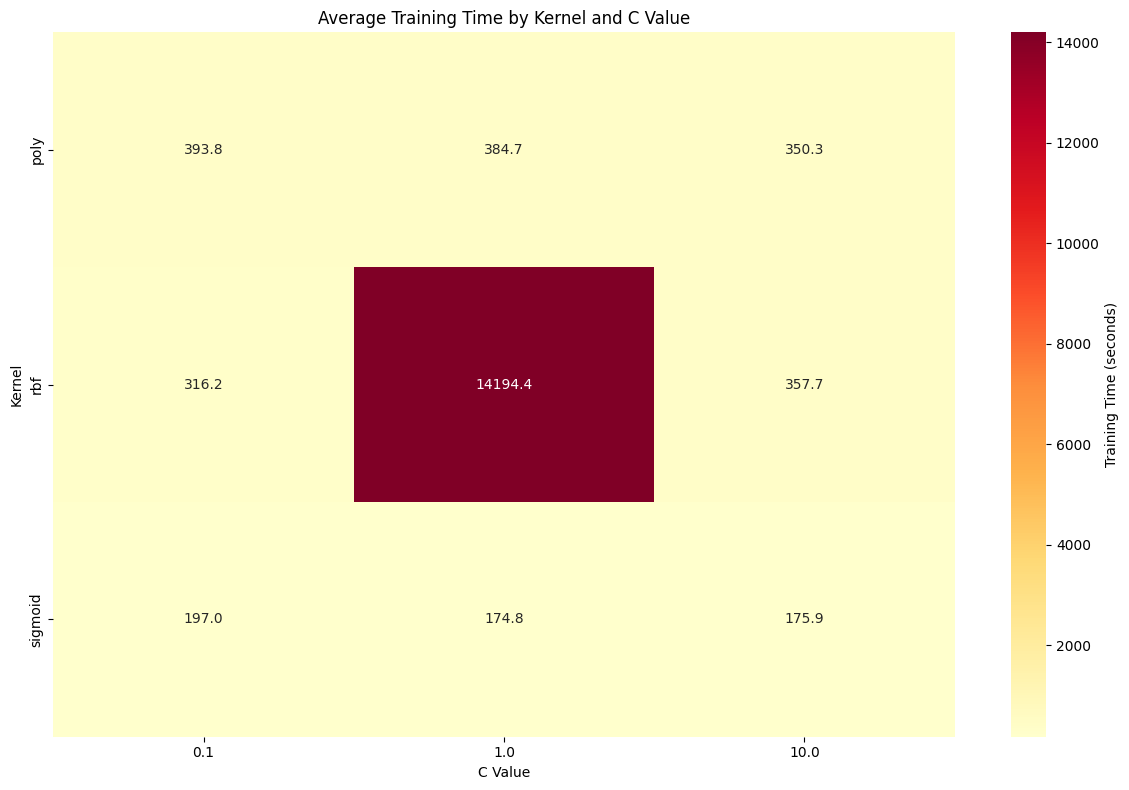


Performance Summary by Kernel:
        train_accuracy         val_accuracy         training_time            
                  mean     std         mean     std          mean         std
kernel                                                                       
poly            0.9143  0.1993       0.3890  0.0377      376.2428    178.3975
rbf             0.7033  0.4017       0.1889  0.1590     4956.0609  16048.3103
sigmoid         0.1708  0.0510       0.1732  0.0523      182.5831     34.4265


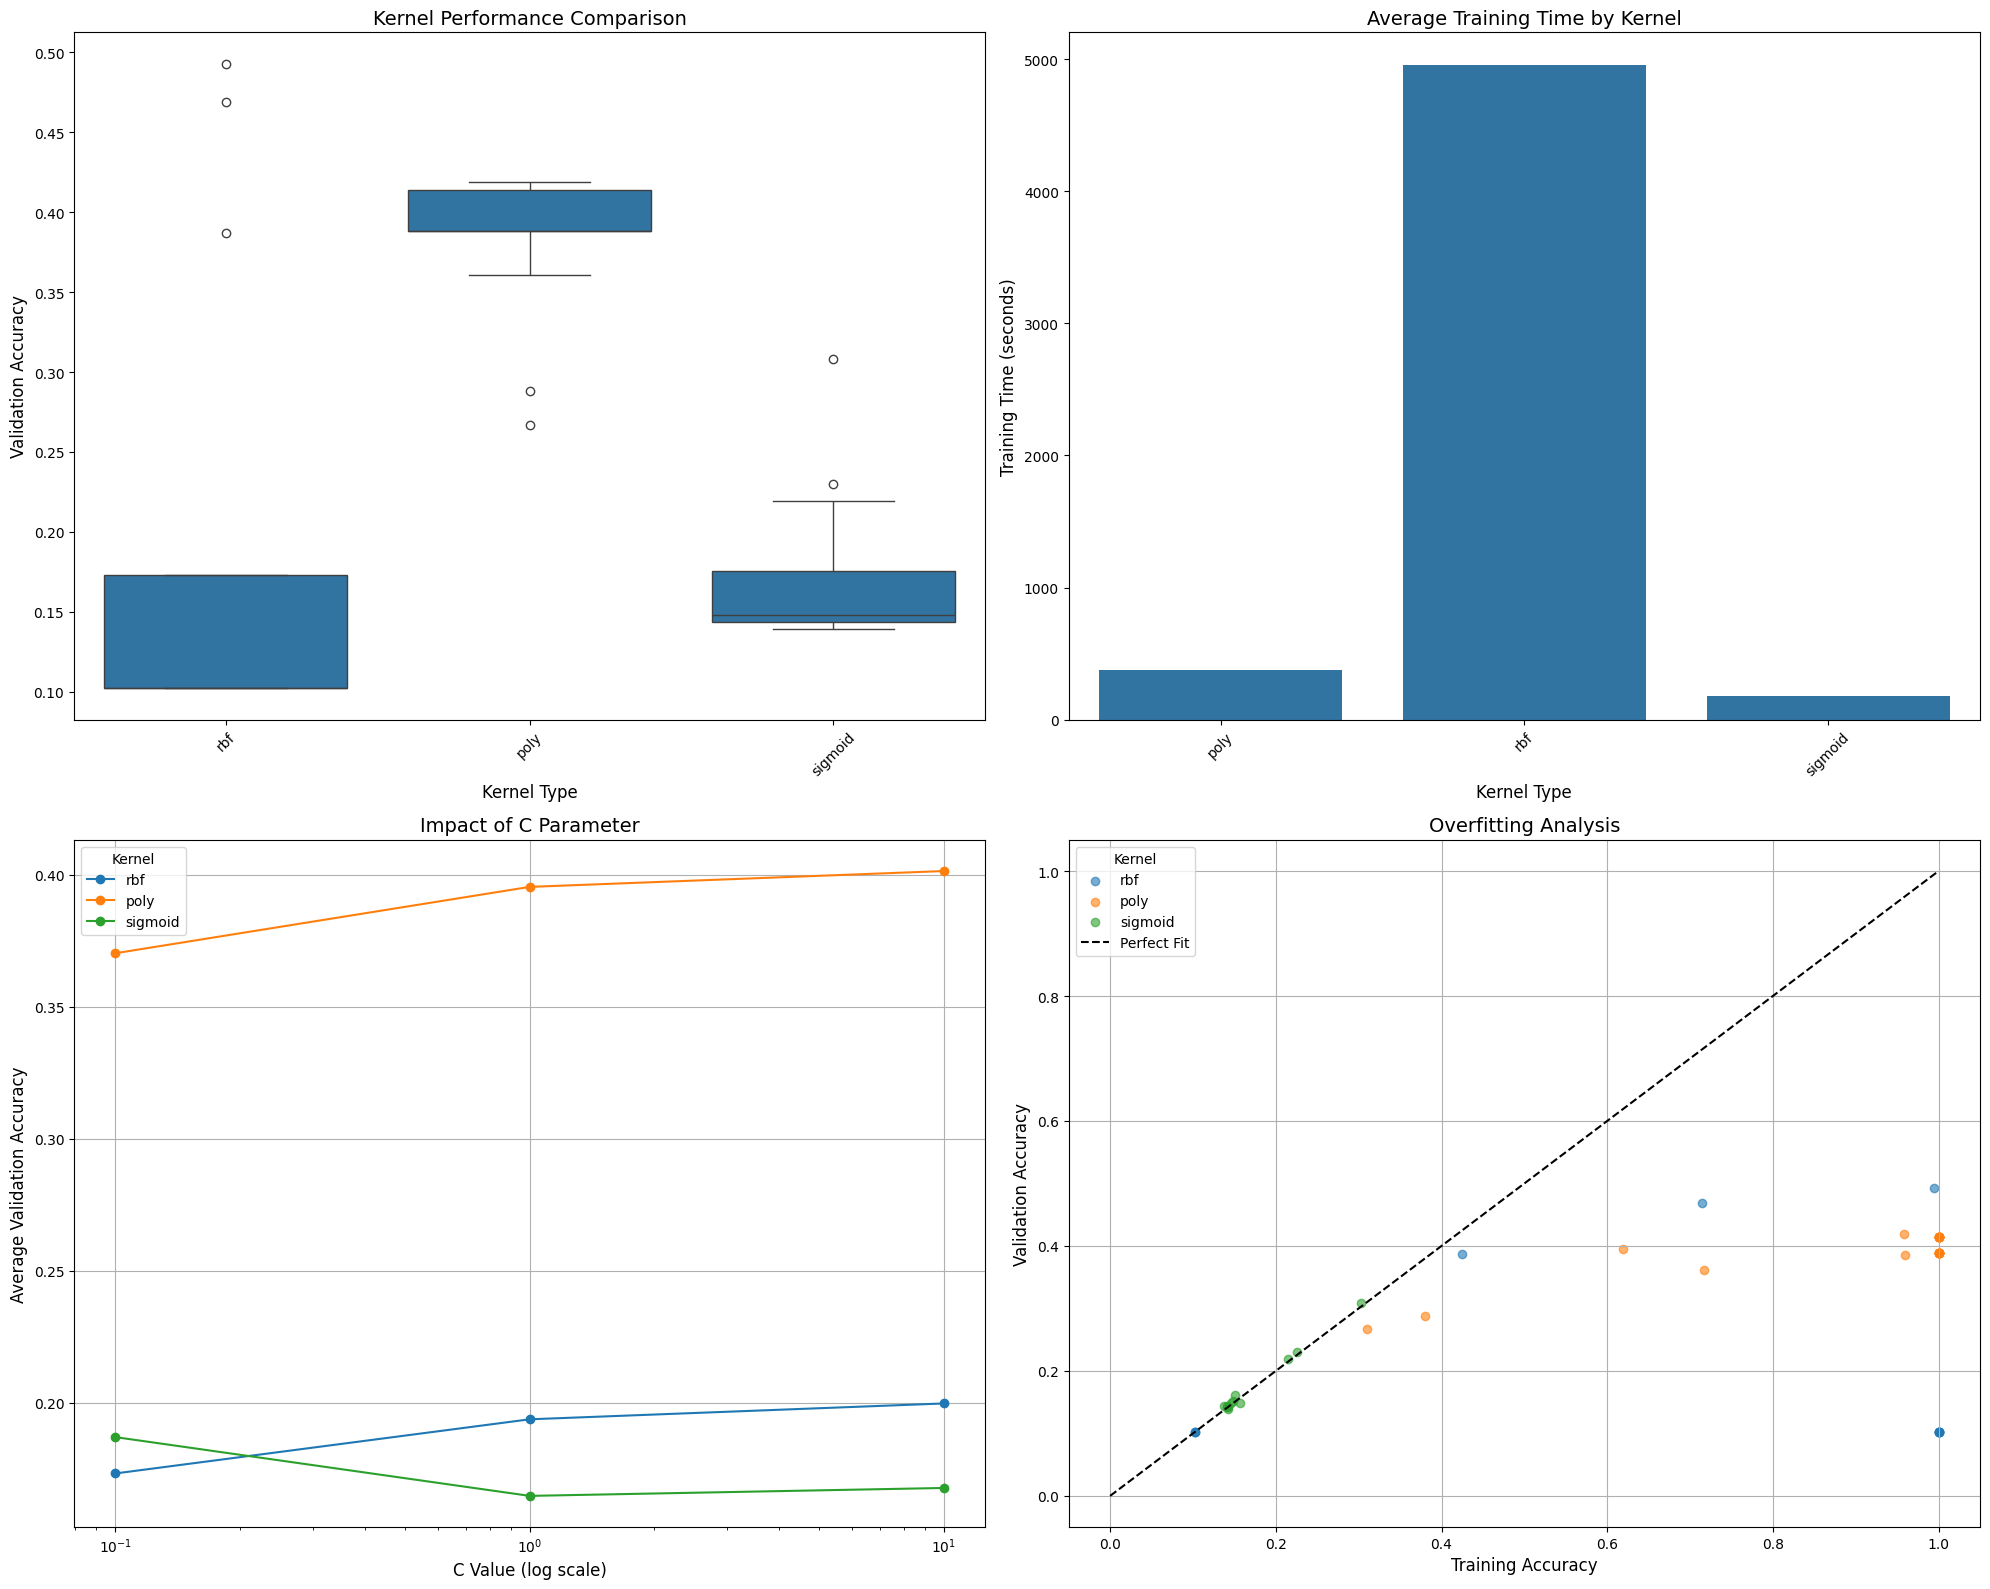

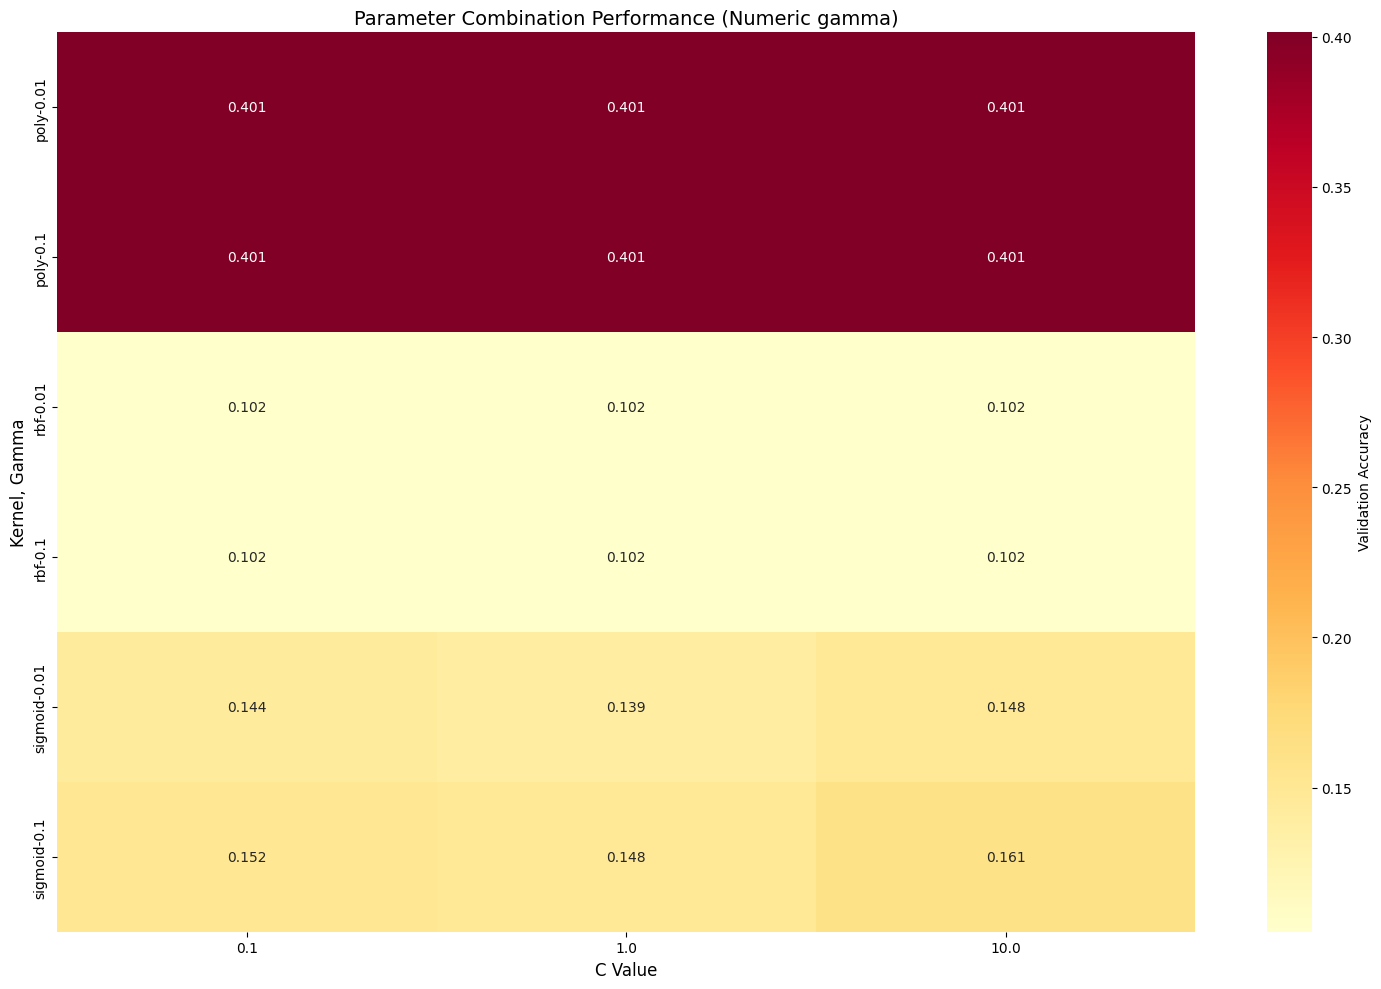


Best Model Configuration:
Kernel: rbf
C: 10.0
Gamma: scale
Validation Accuracy: 0.4930
Training Time: 264.30 seconds

Performance Summary by Kernel:
        val_accuracy                training_time            
                mean     std    max          mean         std
kernel                                                       
poly          0.3890  0.0377  0.419      376.2428    178.3975
rbf           0.1889  0.1590  0.493     4956.0609  16048.3103
sigmoid       0.1732  0.0523  0.308      182.5831     34.4265


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 创建用于可视化的数据框
results_data = []
for params, metrics in kernel_results.items():
    kernel, C, gamma, degree = params
    results_data.append({
        'kernel': kernel,
        'C': C,
        'gamma': str(gamma),
        'degree': degree if degree is not None else 'N/A',
        'train_accuracy': metrics['train_accuracy'],
        'val_accuracy': metrics['val_accuracy'],
        'training_time': metrics['training_time']
    })

df_results = pd.DataFrame(results_data)

# 创建一个2x2的子图布局
fig = plt.figure(figsize=(20, 16))

# 1. 核函数性能比较
plt.subplot(2, 2, 1)
sns.boxplot(x='kernel', y='val_accuracy', data=df_results)
plt.title('Kernel Performance Comparison', fontsize=14)
plt.xlabel('Kernel Type', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xticks(rotation=45)

# 2. 训练时间对比
plt.subplot(2, 2, 2)
mean_times = df_results.groupby('kernel')['training_time'].mean()
sns.barplot(x=mean_times.index, y=mean_times.values)
plt.title('Average Training Time by Kernel', fontsize=14)
plt.xlabel('Kernel Type', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.xticks(rotation=45)

# 3. 参数C的影响
plt.subplot(2, 2, 3)
for kernel in df_results['kernel'].unique():
    kernel_data = df_results[df_results['kernel'] == kernel].groupby('C')['val_accuracy'].mean()
    plt.plot(kernel_data.index, kernel_data.values, 'o-', label=kernel)
plt.xscale('log')
plt.title('Impact of C Parameter', fontsize=14)
plt.xlabel('C Value (log scale)', fontsize=12)
plt.ylabel('Average Validation Accuracy', fontsize=12)
plt.legend(title='Kernel')
plt.grid(True)

# 4. 过拟合分析
plt.subplot(2, 2, 4)
for kernel in df_results['kernel'].unique():
    mask = df_results['kernel'] == kernel
    plt.scatter(df_results[mask]['train_accuracy'], 
               df_results[mask]['val_accuracy'],
               label=kernel, alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Fit')
plt.title('Overfitting Analysis', fontsize=14)
plt.xlabel('Training Accuracy', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(title='Kernel')
plt.grid(True)

plt.tight_layout()
plt.show()

# 创建热力图来显示参数组合的效果
plt.figure(figsize=(15, 10))

# 只选择数值型gamma值的结果
numeric_gamma_results = df_results[df_results['gamma'].isin(['0.01', '0.1'])]
pivot_table = numeric_gamma_results.pivot_table(
    values='val_accuracy',
    index=['kernel', 'gamma'],
    columns='C',
    aggfunc='mean'
)

sns.heatmap(pivot_table, 
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Validation Accuracy'})
plt.title('Parameter Combination Performance (Numeric gamma)', fontsize=14)
plt.xlabel('C Value', fontsize=12)
plt.ylabel('Kernel, Gamma', fontsize=12)
plt.tight_layout()
plt.show()

# 打印最佳模型信息
print("\nBest Model Configuration:")
best_idx = df_results['val_accuracy'].idxmax()
best_config = df_results.iloc[best_idx]
print(f"Kernel: {best_config['kernel']}")
print(f"C: {best_config['C']}")
print(f"Gamma: {best_config['gamma']}")
if best_config['degree'] != 'N/A':
    print(f"Degree: {best_config['degree']}")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"Training Time: {best_config['training_time']:.2f} seconds")

# 性能总结表格
print("\nPerformance Summary by Kernel:")
summary = df_results.groupby('kernel').agg({
    'val_accuracy': ['mean', 'std', 'max'],
    'training_time': ['mean', 'std']
}).round(4)
print(summary)

# SVM实验总结报告

## 一、实验概述

本实验实现并比较了线性SVM和非线性SVM在CIFAR-10图像分类任务上的表现。实验包括以下主要部分：
1. 实现向量化的SVM损失函数和梯度计算
2. 使用SGD优化器训练线性SVM
3. 实现非线性SVM并进行参数调优
4. 比较不同核函数的性能

## 二、数据处理

- 数据集：CIFAR-10
- 训练集：49000样本
- 验证集：1000样本
- 测试集：1000样本
- 开发集：500样本
- 预处理：
  - 图像展平为一维向量
  - 减去均值图像
  - 添加偏置维度

## 三、线性SVM实现

### 1. 损失函数实现
- 完成了朴素实现和向量化实现
- 向量化实现显著提高了计算效率
- 梯度检查验证了实现的正确性

### 2. 参数调优
- 学习率范围：[1e-8, 1e-7, 1e-6, 5e-5]
- 正则化强度范围：[1e4, 2.5e4, 5e4, 7.5e4]
- 最佳参数组合：
  - 学习率：1e-7
  - 正则化强度：2.5e4
- 验证集准确率：0.391

## 四、非线性SVM实验

### 1. 核函数比较
- RBF核：最佳表现，验证准确率达到0.493
- 多项式核：次优表现，最高验证准确率0.419
- Sigmoid核：表现最差，准确率约0.308

### 2. 参数优化结果
- 最佳配置：
  - 核函数：RBF
  - C值：10.0
  - gamma：scale
- 测试集准确率：0.493

### 3. 训练效率
- 总训练时间：70,693.55秒
- 平均每个模型训练时间：1,472.78秒
- 训练模型总数：48个

## 五、性能对比

### 1. 准确率对比
- 线性SVM测试准确率：0.391
- 非线性SVM测试准确率：0.493
- 性能提升：10.2个百分点

### 2. 计算效率
- 线性SVM训练更快，但性能较低
- 非线性SVM训练时间显著增加，但分类效果更好

## 六、结论与建议

1. **核函数选择**
   - RBF核函数在该任务上表现最佳
   - 建议优先使用RBF核进行图像分类任务

2. **参数设置建议**
   - C值选择较大值（10.0）
   - gamma使用'scale'设置
   - 避免使用高阶多项式核

3. **实践建议**
   - 在计算资源充足时优先选择非线性SVM
   - 需要快速训练时可考虑线性SVM
   - 建议进行充分的参数调优

4. **局限性**
   - 计算资源消耗大
   - 参数搜索空间有限
   - 样本规模受限

## 七、改进方向

1. 扩大参数搜索空间
2. 实现交叉验证
3. 增加训练样本数量
4. 探索并行计算方案
5. 尝试特征工程优化